# Raport 2: Generowanie procesów losowych.

#### Agata Żabska 268760, Szymon Stano 268776
---

## Zaimportowanie niezbędnych bibliotek i funkcji:

In [221]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
from numba import njit
from tqdm import tqdm
from matplotlib import cm
from copy import copy
import matplotlib
from fitter import Fitter

## 1. Szum telegraficzny.

Zadanie to polegało na przedstawieniu trajektorii zadanego procesu Szumu Telegraficznego oraz policzeniu numerycznie wartości $E(X_t)$ oraz $Cov(X_0, X_t)$. Ich implementację przedstawiamy poniżej.

### 1.1 Trajektoria

Z racji faktu przybierania przez proces Poissona za wartości kolejne liczby całkowite,
wyrażenie $(-1)^{N_t}$ będzie wynosić naprzemiennie 1 oraz -1. Jego kolejne wartości wraz
z przyrostem czasu możemy przedstawić jako tablicę o zadanej sekwencji: $[ 1,-1, 1, -1,...]$,
którą generować będziemy poniższym kodem.

In [222]:
def minus_ones_and_ones_array(n):
    array = np.tile([1, -1], n // 2)  # Generowanie początkowej część tablicy
    if n % 2 != 0:
        array = np.append(array, 1)  # Dodanie ostatniego elementu, jeśli n jest nieparzyste
    return array

Wygenerujemy następnie czasy jednorodnego procesu poissona z parametrem $\lambda = 1$ i na ich podstawie stworzymy trajektorię Szumu Telegraficznego.


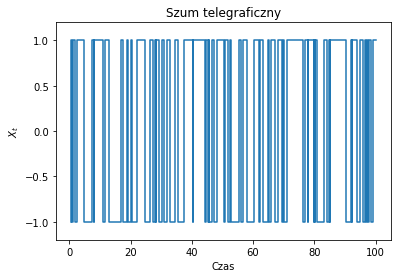

In [223]:
Time = []
lmbd = 1
sum = 0
T = 100
while sum < T:
    t = np.random.exponential(1/lmbd)
    sum += t
    Time.append(sum)


D = np.random.choice([-1, 1])
array = minus_ones_and_ones_array(len(Time))
values = D * array

plt.step(Time, values)
plt.title("Szum telegraficzny")
plt.xlabel('Czas')
plt.ylim([-1.2, 1.2])
plt.ylabel("$X_t$")
plt.show()

### 1.2 Funkcja średniej
Do generowania $X_t$ wykorzystaliśmy fakt, że $N_t \sim Poiss(\lambda t)$. Funkcja do liczenia średniej $m:=E(X_t)$ przedstawia się następująco. 

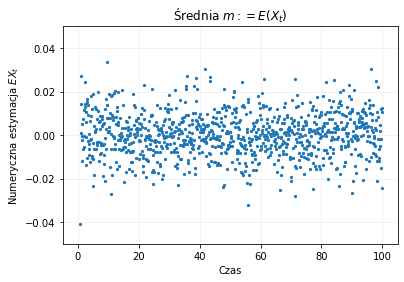

In [224]:
def mean_in_time(time_array, length, lambd):
    """Funkcja numerycznego liczenia średniej.
    Przyjmuje parametry:
    time_array - tablica z wartościami czasów, dla których liczona będzie średnia
    length - długość generowanych prób
    lambd - parametr lambda rozkładu Poissona

    Funkcja zwraca:
    output -  tablica ze średnimi arytmetycznymi z prób dla kolejnych czasów
    
    Dla każdego czasu t z tablicy time_array generowane jest n=length próbek X_t
    z procesu Szumu Telegraficznego, które następnie są uśrednianie i zapisywane
    na odpowiednim miejscu w tablicy output
    """
    arr = np.array([-1, 1])
    output = np.empty(len(time_array))
    for i, t in np.ndenumerate(time_array):
        D = np.random.choice(arr)
        poisson_samples = np.random.poisson(lambd * t, size=length)
        output[i] = np.mean(D * (-1)**poisson_samples)
    return output


n = 10**4
lmbd = 2
mtime = np.linspace(0, 100, 10**3)

mean_outputs = mean_in_time(mtime, n, lmbd)

plt.scatter(mtime, mean_outputs, s=5)
plt.ylim(-0.05, 0.05)
plt.title("Średnia $m:=E(X_t)$")
plt.xlabel("Czas")
plt.ylabel("Numeryczna estymacja $EX_t$")
plt.grid(alpha=0.2)
plt.show()

### 1.3 Kowariancja
W podobny sposób co do liczenia średniej, lecz również z generowaniem próbek $X_0$ na początku każdej trajektorii, zaimplementowaliśmy algorytm do liczenia kowariancji $r:=Cov(X_0,X_t)$. Wykorzystaliśmy tutaj również fakt, że $N_0 = 0$, a więc $X_0 = D$. Kowariancję policzyliśmy również sposobem analitycznym, by móc później porównać ją z otrzymanymi wynikami. Mamy więc:

$$Cov(X_0, X_t)=Cov(D, D(-1)^{Poiss(\lambda t)}) = E(D^2(-1)^{Poiss(\lambda t)}) - E(D)E(D(-1)^{Poiss(\lambda t)}).$$

Jak możemy zauważyć, wyrażenie $D^2$ zawsze będzie przyjmować wartość $1$, natomiast $E(D)$ wynosi $0$, stąd otrzymujemy:

$$Cov(X_0, X_t) = E((-1)^{Poiss(\lambda t)}) = \sum_{k=0}^{\infty}(-1)^k \cdot \frac{1}{k!}(\lambda t)^k e^{-\lambda t} = e^{-\lambda t} \sum_{k=0}^{\infty} \frac{(-\lambda t)^k}{k!} =e^{-\lambda t}e^{-\lambda t} = e^{-2\lambda t} .$$

In [225]:
@njit
def covariance_x0_xt(time_array, length, lambd):
    """Funkcja numerycznego liczenia kowariancji.
    Przyjmuje parametry:
    time_array - tablica z wartościami czasów, dla których liczona będzie średnia
    length - długość generowanych prób
    lambd - parametr lambda rozkładu Poissona

    Funkcja zwraca:
    output -  tablica z kowariancjami z prób dla kolejnych czasów
    """
    output = np.empty(len(time_array))
    arr = np.array([-1, 1])
    for i, t in np.ndenumerate(time_array):
        x_zeros = np.random.choice(arr, length)   # X_0 = D
        D = x_zeros
        poisson_samples = np.random.poisson(lambd * t, size=length)
        x_t = D * (-1)**poisson_samples
        output[i] = np.cov(x_zeros, x_t)[0, 1]
    return output


"Kompilacja"
test_time = np.array([1, 2, 3])
y = covariance_x0_xt(test_time, 10**4, 2)

n = 10**4   # ilość trajektorii (uśrednień)
lmbd = 2   # parametr lambda procesu Poissona
ttime = np.linspace(0, 10, 10**3)   # czasy, dla których będziemy liczyć kowariancję

cov_outputs = covariance_x0_xt(ttime, n, lmbd)

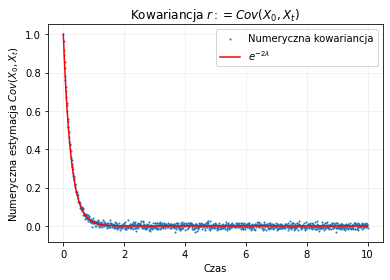

In [226]:
plt.scatter(ttime, cov_outputs, s=1, label="Numeryczna kowariancja")
plt.plot(ttime, np.exp(-2*lmbd*ttime), color='r', label="$e^{-2  \lambda}$")
plt.xlabel("Czas")
plt.ylabel("Numeryczna estymacja $Cov(X_0,X_t)$")
plt.title("Kowariancja $r:=Cov(X_0,X_t)$")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

**Wnioski:**
Jak możemy zaobserwować, trajektoria Szumu Telegraficznego naprzemiennenie przyjmuje wartości -1 oraz 1. Na tej podstawie mogliśmy wnioskować, że wartość średnia oscylować będzie w okolicach 0 i tak też się stało. Numerycznie wyznaczona kowariancja pokryła się z jej analitycznym odpowiednnikiem, co wskazuje na poprawność symulacji. 

## 2. Efektywność generacji niejednorodnego procesu Poissona.

W tym zadaniu sprawdziliśmy średnią efektywność oraz czas średni trwania generacji niejednorodnego procesu Poissona metodą przerzedzania. Przeanalizowaliśmy te zagadnienia dla trzch przykładowych funkcji $\lambda$ - funkcji stałej, wolno oraz szybkozmiennej na odcinku $[0, T]$. W naszym przypadku:
* $\lambda_{1}(t) = 1,$

* $\lambda_{2}(t) = \frac{1}{10} \cdot t,$ 

* $\lambda_{3}(t) = 10 \cdot t^2.$

Na koniec porównaliśmy czasy generacji metodą przerzedzania z czasami generacji metodą odwrotnej dystrybuanty.

In [227]:
def lmbd1(t):
    """przykładowa funkcja intensywności - funkcja stała"""
    return 1

def lmbd2(t):
    """przykładowa funckja intensywności - funkcja wolnozmienna"""
    return 0.1 * t

def lmbd3(t):
    """przykładowa funckja intensywności - funkcja szybkozmienna"""
    return 10 * t**2

### 2.1 Metoda przerzedzania

In [228]:
def PoissonProcess(lmbd, lmbd_max, T):
    """Funkcja przyjmuje trzy argumenty:
    lmbd - funkcja intensywności
    lmbd_max - maksimum funkcji intensywności na odcinku [0, T]
    T - długość odcinka
    
    Zwraca:
    accepted - tablica zaakceptowanych punktów
    efficiency - efektywność generacji 

    Służy do generowania niejednorodnego procesu Poissona
    metodą przerzedzania
    """
    accepted = []
    count = 0 
    ti = 0 
    s = 0
    while(s < T):
        ti += np.random.exponential(1/lmbd_max)
        u = np.random.uniform(0, 1)
        if (u <= lmbd(ti)/lmbd_max):
            s=ti
            accepted.append(s)
            count += 1
        else:
            count += 1
    accepted = np.array(accepted)
    efficiency = len(accepted)/count
    return accepted, efficiency

In [229]:
T = 10
M = 500

lmbd1_max = 1
lmbd2_max = 0.1 * T
lmbd3_max = 10 * T**2
Lmbd = [lmbd1, lmbd2, lmbd3]
Lmbd_max = [lmbd1_max, lmbd2_max, lmbd3_max]

for j in range(len(Lmbd)):
    prob = 0
    start = time.time()
    for i in range(M):
        PoissonProcess(Lmbd[j], Lmbd_max[j], T)
    end = time.time()
    for i in range(M):
        prob += PoissonProcess(Lmbd[j], Lmbd_max[j], T)[1]

    print(f"Średnia efektywność dla lambda{j+1}:        ", prob/M)
    print(f"Średni czas generacji dla lambda{j+1}:      ", (end-start)/M)

Średnia efektywność dla lambda1:         1.0
Średni czas generacji dla lambda1:       4.5676708221435545e-05
Średnia efektywność dla lambda2:         0.5417609405091404
Średni czas generacji dla lambda2:       4.5432567596435545e-05
Średnia efektywność dla lambda3:         0.3335855818535476
Średni czas generacji dla lambda3:       0.048153393268585205


### 2.2 Metoda odwrotnej dystrybuanty:

In [230]:
def m1(t):
    """całka z funkcji intensywności lmbd1"""
    return t

def m2(t):
    """całka z funkcji intensywności lmbd2"""
    return 0.05 * t**2

def m3(t):
    """całka z funkcji intensywności lmbd3"""
    return 10/3 * t**3

mT1 = m1(T)
mT2 = m2(T)
mT3 = m3(T)

def invF1():
    """dystrybuanta odwrotna dla lmbd1"""
    u = np.random.uniform(0,1)
    return u * mT1

def invF2():
    """dystrybuanta odwrotna dla lmbd2"""
    u = np.random.uniform(0,1)
    return np.sqrt(u * mT2/0.05)

def invF3():
    """dystrybuanta odwrotna dla lmbd3"""
    u = np.random.uniform(0,1)
    return np.power(3/10 * u * mT3, 1/3)

In [231]:
def PoissonProcess_invF(invF, mT):
    """Funkcja przyjmuje dwa argumenty:
    invF - wzór na odpowiednią dystrybuantę odwrotną
    mT - wartość całki z funkcji intensywności 
    w punkcie T

    Zwraca S - tablicę wartości procesu

    Służy do generowania niejednorodnego procesu
    Poissona metodą odwrotnej dystrybuanty"""
    
    Nt = np.random.poisson(mT)
    S = np.zeros(int(Nt))
    s = 0
    for i in range(int(Nt)):
        s = invF()
        S[i] = s
    S = np.sort(S)
    S = np.insert(S, 0, 0)
    return S

In [232]:
mT = [mT1, mT2, mT3]
invF = [invF1, invF2, invF3]

for j in range(len(invF)):
    start = time.time()
    for i in range(M):
        PoissonProcess_invF(invF[j], mT[j])
    end = time.time()

    print(f"Średni czas generacji dla lambda{j+1}:      ", (end-start)/M)

Średni czas generacji dla lambda1:       6.331062316894531e-05
Średni czas generacji dla lambda2:       4.5017242431640626e-05


Średni czas generacji dla lambda3:       0.01540228796005249


Dodatkowo, zweryfikowaliśmy poprawność naszych symulacji porównując trajektorie procesu z wykresem całki z funkcji intensywności. Otrzymane rezultaty dla $\lambda_2$ świadczą o poprawności symulacji. Analogicznie można dokonać sprawdzenia dla pozostałych funkcji.

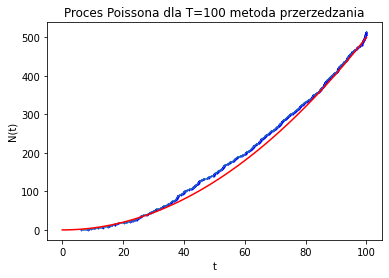

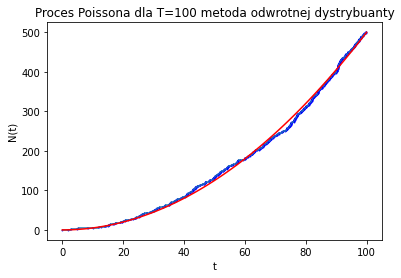

In [233]:
T = 100
lmbd_max = lmbd2(T)
process = PoissonProcess(lmbd2, lmbd_max, T)[0]
y = np.array([i for i in range (len(process))])
x = np.array([i for i in range(T+1)])

for i in range (len(y) - 1):
    plt.hlines(y[i], process[i], process[i+1])
    plt.scatter(process[i], y[i], facecolors = "b", edgecolors="b", s = 0.6)
    plt.scatter(process[i+1], y[i], facecolors = "none", edgecolors= "b", s = 0.6)
plt.plot(x, m2(x), color = "r")
plt.xlabel("t")
plt.ylabel("N(t)")
plt.title("Proces Poissona dla T={} metoda przerzedzania".format(T))
plt.show()

mT2 = m2(T)
process = PoissonProcess_invF(invF2, mT2)
y = np.array([i for i in range(len(process))])

for i in range (len(y) - 1):
    plt.hlines(y[i], process[i], process[i+1])
    plt.scatter(process[i], y[i], facecolors = "b", edgecolors="b", s = 0.8)
    plt.scatter(process[i+1], y[i], facecolors = "none", edgecolors= "b", s = 0.8)
plt.plot(x, m2(x), color = "r")
plt.xlabel("t")
plt.ylabel("N(t)")
plt.title("Proces Poissona dla T={} metoda odwrotnej dystrybuanty".format(T))
plt.show()

**Wnioski:**
* Wraz ze wzrostem tempa zmienności funkcji $\lambda$:
    * efektywność metody przerzedzania spada,
    * czas generacji procesu się wydłuża.
$$$$
* W ogólności metoda odwrotnej dystrybuanty jest szybsza. Wynika to z tego, że od razu generujemy "właściwe" wartości procesu i nie musimy stosować metody akceptacji-odrzucenia do wybrania odpowiednich punktów. 

* W przypadku funkcji stałej szybsza okazuje się metoda przerzedzania. Jest to spowowane tym, że dla stałej funkcji $\lambda$ efektywność wynosi 100%, czyli nie odrzucamy żadnych punktów. Przy metodzie odwrotnej dystrybuanty wykonujemy bardziej kosztowne obliczenia i w tym przypadku nie jest ona opłacalna. Oczywiście dla stałej funkcji $\lambda$ otrzymujemy jednorodny proces Poissona.

## 3. Estymacja niejednorodnej intensywności.

Zaimplementowana metoda estymacji polega na wielokrotnym symulowaniu losowych miar Poissonowskich, wygenerowanych metodą przerzedzania. Za każdym razem tworzymy histogram, zbierając dane o częstotliwościach wpadania w poszczególne przedziały. Na koniec uśredniamy otrzymane w ten sposób częstotliwości, przez co jesteśmy w stanie dobrze estymować niejednorodną funkcję intensywności użytą do wygenerowania danej miary Poissonowskiej.

### 3.1 Przypadek 1D

W tym przypadku przyjmiemy funkcję intensywności $\boldsymbol{\lambda}(x) =   \lambda \cdot ( sin(x) + 2)$. Losową miarę Poissonowską będziemy generować na odcinku $A = [0, a]$. Otrzymujemy więc:
$$\int_{0}^{a}\lambda \cdot ( sin(x) + 2) dx =\lambda( 2a - cos(a) + 1).$$
 Czyli:
 $$N(A) \sim Poiss(\lambda( 2a - cos(a) + 1)).$$

Przyjmijmy teraz parametry do symulacji:

In [234]:
lmbd = 100
lmbd_max = 3 * lmbd
a = 20

W tej części wygenerujemy pojedynczą próbę symulacji miary Poissonowskiej.

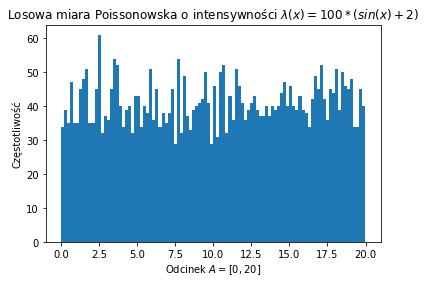

In [235]:
n_omega = np.random.poisson(lmbd * (2*a - np.cos(a) + 1))

px = np.random.uniform(0, a, n_omega)
U = np.random.uniform(size=n_omega)
probability = lmbd * (np.sin(px) + 2) / lmbd_max
boolean_array = U <= probability
px2 = px[boolean_array]

bins = 5 * a
counts, intervals = np.histogram(px, bins=bins)
plt.hist(px, bins=bins)
plt.title(f'Losowa miara Poissonowska o intensywności $\u03BB(x) = {lmbd} * (sin(x) + 2)$')
plt.xlabel(f"Odcinek $A = [0, {a}]$")
plt.ylabel("Częstotliwość")
plt.show()

Teraz zwiększymy ilość prób i uśrednimy otrzymane w ten sposób częstotliwości. 

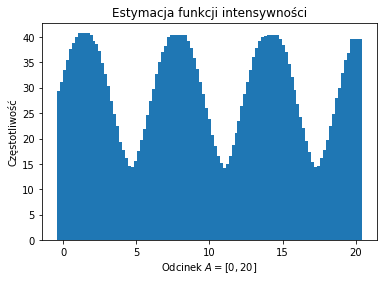

In [236]:
n = 500
overall_counts = np.zeros(bins)
for i in range(n):
    n_omega = np.random.poisson(lmbd * (2 * a - np.cos(a) + 1))

    px = np.random.uniform(0, a, n_omega)
    U = np.random.uniform(size=n_omega)
    probability = lmbd * (np.sin(px) + 2) / lmbd_max
    boolean_array = U <= probability
    px2 = px[boolean_array]

    counts, intervals = np.histogram(px2, bins=bins)
    overall_counts += counts   # dodajemy otrzymane częstotliwości na konkretnych komórkach

x = np.linspace(0, a, int(bins))
plt.bar(x, overall_counts/n)   # uśredniamy łączną liczbę wystąpień przez ilość realizacji
plt.title(f'Estymacja funkcji intensywności')
plt.xlabel(f"Odcinek $A = [0, {a}]$")
plt.ylabel("Częstotliwość")
plt.show()

### 3.2 Przypadek 2D

W tym przypadku przyjmiemy funkcję intensywności $\boldsymbol{\lambda}(x,y) =   \lambda \cdot ( sin(x)sin(y) + 1)$. Losową miarę Poissonowską będziemy generować na kwadracie $A = [-a, a] \times [-a, a]$. Otrzymujemy więc:
$$\int_{-a}^{a}\int_{-a}^{a}\lambda \cdot ( sin(x)sin(y) + 1) dx = \lambda \cdot 4a^2.$$

Czyli:
$$N(A) \sim Poiss(\lambda \cdot 4a^2).$$

Przyjęliśmy parametry:

In [237]:
lmbd = 100
a = 6

I przeprowadziliśmy jedną próbę symulacji danej losowej miary Poissonowskiej.

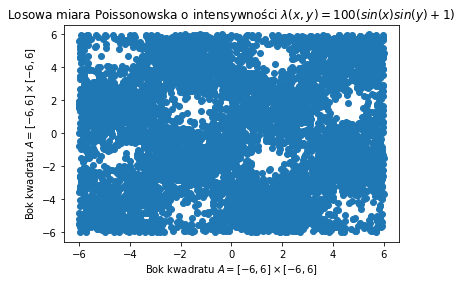

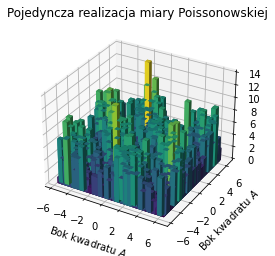

In [238]:
lmbd_max = 2 * lmbd
bins = 50

n_omega = np.random.poisson(lmbd * 4 * a**2)

px = np.random.uniform(-a, a, n_omega)
py = np.random.uniform(-a, a, n_omega)
U = np.random.uniform(size=n_omega)
probability = lmbd * (np.sin(px) * np.sin(py) + 1) / lmbd_max
boolean_array_v2 = U <= probability
px2 = px[boolean_array_v2]
py2 = py[boolean_array_v2]

plt.scatter(px2, py2)
plt.title(f'Losowa miara Poissonowska o intensywności $\u03BB(x,y) = {lmbd} (sin(x)sin(y)+1)$')
plt.xlabel(f'Bok kwadratu $A = [{-a}, {a}] \\times [{-a}, {a}]$')
plt.ylabel(f'Bok kwadratu $A = [{-a}, {a}] \\times [{-a}, {a}]$')
plt.show()


hist, xedges, yedges = np.histogram2d(px2, py2, bins=bins, range=[[-a, a], [-a, a]])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

cmap = matplotlib.colormaps['viridis']
max_height = np.max(dz)
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz]
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=rgba)
plt.title("Pojedyncza realizacja miary Poissonowskiej")
plt.xlabel(f'Bok kwadratu $A$')
plt.ylabel(f'Bok kwadratu $A$')
plt.show()

Teraz zwiększymy ilość prób i uśrednimy otrzymane w ten sposób częstotliwości.

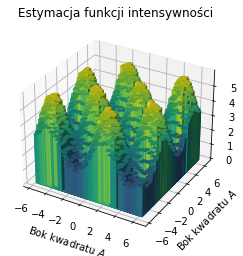

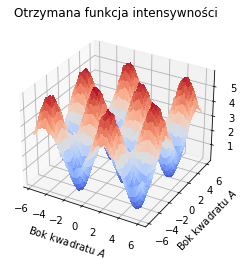

In [239]:
lmbd = 100
lmbd_max = 2 * lmbd

n = 500
bins = 50
hist_out = np.zeros(shape=(bins, bins))
a = 6
"funkcja: lmbd(sin(x)*sin(y) + 1)"
for i in range(n):
    n_omega = np.random.poisson(lmbd * 4 * a**2)

    px = np.random.uniform(-a, a, n_omega)
    py = np.random.uniform(-a, a, n_omega)

    U = np.random.uniform(size=n_omega)
    probability = lmbd * (np.sin(px) * np.sin(py) + 1) / lmbd_max
    boolean_array_v2 = U <= probability

    px2 = px[boolean_array_v2]
    py2 = py[boolean_array_v2]


    hist, xedges, yedges = np.histogram2d(px2, py2, bins=bins, range=[[-a, a], [-a, a]])
    hist_out += hist

hist_out /= n

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
x = copy(xpos)
y = copy(ypos)
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist_out.ravel()

cmap = matplotlib.colormaps['viridis']
max_height = np.max(dz)
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz]
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=rgba)
plt.title(f'Estymacja funkcji intensywności')
plt.xlabel(f'Bok kwadratu $A$')
plt.ylabel(f'Bok kwadratu $A$')
plt.show()


"""Tworzenie gładkiego wykresu na podstawie histogramu 2d"""
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x, y, hist_out, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title("Otrzymana funkcja intensywności")
plt.xlabel(f'Bok kwadratu $A$')
plt.ylabel(f'Bok kwadratu $A$')
plt.show()

Rozważyliśmy również drugą funkcję intensywności wyrażającą się wzorem $\boldsymbol{\lambda}(x,y) =   \lambda \cdot ( xy + a^2)$. Losową miarę Poissonowską będziemy generować na kwadracie $A = [-a, a] \times [-a, a]$. Otrzymujemy więc:
$$\int_{-a}^{a}\int_{-a}^{a}\lambda \cdot ( xy + a^2) dx = \lambda \cdot 4a^4.$$
Czyli:
$$N(A) \sim Poiss(\lambda \cdot 4a^4).$$
I postępowaliśmy tak jak w powyższych przypadkach.

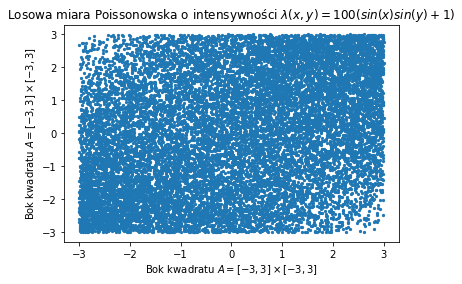

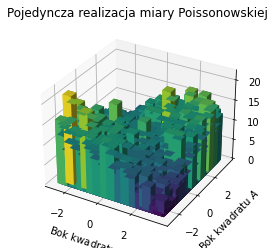

In [240]:
a = 3
lmbd = 100  # współczynnik przy funkcji
lmbd_max = 2 * a**2 * lmbd
bins = 50


n_omega = np.random.poisson(lmbd * 4 * a**4)

px = np.random.uniform(-a, a, n_omega)
py = np.random.uniform(-a, a, n_omega)

U = np.random.uniform(size=n_omega)
probability = lmbd * (px * py + a**2) / lmbd_max
boolean_array_v2 = U <= probability
px2 = px[boolean_array_v2]
py2 = py[boolean_array_v2]

plt.scatter(px2, py2, s=5)
plt.title(f'Losowa miara Poissonowska o intensywności $\u03BB(x,y) = {lmbd} (sin(x)sin(y)+1)$')
plt.xlabel(f'Bok kwadratu $A = [{-a}, {a}] \\times [{-a}, {a}]$')
plt.ylabel(f'Bok kwadratu $A = [{-a}, {a}] \\times [{-a}, {a}]$')
plt.show()


hist, xedges, yedges = np.histogram2d(px2, py2, bins=bins, range=[[-a, a], [-a, a]])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
x = copy(xpos)
y = copy(ypos)
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

cmap = matplotlib.colormaps['viridis']
max_height = np.max(dz)
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz]
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=rgba)
plt.title("Pojedyncza realizacja miary Poissonowskiej")
plt.xlabel(f'Bok kwadratu $A$')
plt.ylabel(f'Bok kwadratu $A$')
plt.show()

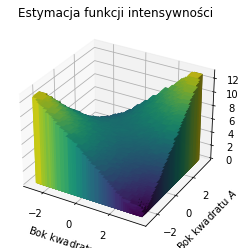

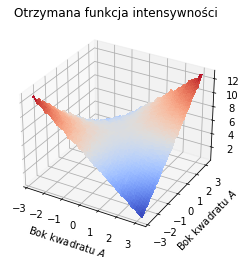

In [241]:
n = 500
bins = 50
hist_out = np.zeros(shape=(bins, bins))
for i in range(n):
    n_omega = np.random.poisson(lmbd * 4 * a**4)

    px = np.random.uniform(-a, a, n_omega)
    py = np.random.uniform(-a, a, n_omega)

    U = np.random.uniform(size=n_omega)
    probability = lmbd * (px * py + a**2) / lmbd_max
    boolean_array_v2 = U <= probability

    px2 = px[boolean_array_v2]
    py2 = py[boolean_array_v2]


    hist, xedges, yedges = np.histogram2d(px2, py2, bins=bins, range=[[-a, a], [-a, a]])
    hist_out += hist
hist_out /= n

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
x = copy(xpos)
y = copy(ypos)
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist_out.ravel()

cmap = matplotlib.colormaps['viridis']
max_height = np.max(dz)
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz]
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=rgba)
plt.title(f'Estymacja funkcji intensywności')
plt.xlabel(f'Bok kwadratu $A$')
plt.ylabel(f'Bok kwadratu $A$')
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x, y, hist_out, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title("Otrzymana funkcja intensywności")
plt.xlabel(f'Bok kwadratu $A$')
plt.ylabel(f'Bok kwadratu $A$')
plt.show()


**Wnioski:**
W obydwu przypadkach wymiarów, wraz ze zwiększeniem ilości realizacji generowania losowej miary Poissonowskiej o niejednorodnej intensywności, jesteśmy w stanie odpowiednio uśrednić częstotliwości występowania punktów w poszczególnych komórkach, dzięki czemu jesteśmy w stanie wyestymować użytą funkcję intensywności.

## 4. Prawdopodobieństwo ruiny.

W tym zadaniu zajęliśmy się generacją trajektorii procesu ryzyka oraz szacowaniem prawdopodobieństwa ruiny. Nasze rozważania przeprowadziliśmy dla procesu o następujących własnościach:
* kapitał początkowy $u = 50$,
* dryf $c = 1$,
* szkody z rozkładu $Exp(\lambda = 1)$ przybywające z intensywnością $intensity = 1$,
* czas $T = 1000$.



In [242]:
u = 50
c = 1
lmbd = 1
intensity = 1
T = 1000

In [243]:
def riskProcess(u, c, T, lmbd, intensity):
    """Funkcja przyjmuje pięć argumentów:
    u - kapitał początkowy
    c - dryf
    T - czas trwania procesu
    lmbd - parametr skali rozkładu wykładniczego, 
    z którego generowane są wartości szkód
    intensity - intensywność przybywania szkód
    
    Zwraca:
    time - tablica czasów, w których proces 
    osiąga poszczególne wartości
    plotter - tablica warości procesu
    
    Służy do generowania procesu ryzyka"""
    
    time = []
    sum_time = 0
    y_value = u
    plotter = []
    time.append(sum_time)
    plotter.append(y_value)
    while sum_time < T:
        t = np.random.exponential(1/intensity)
        L = np.random.exponential(1/lmbd)
        sum_time += t
        time.append(sum_time)
        time.append(sum_time)
        y_value += c*t
        plotter.append(y_value)
        y_value -= L
        plotter.append(y_value)
    return time, plotter

#### 4.1 Wykres trajektorii procesu ryzyka:

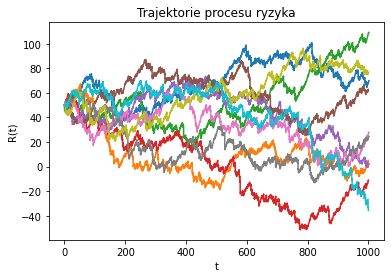

In [244]:
for i in range(10):
    R = riskProcess(u, c, T, lmbd, intensity)
    plt.plot(R[0], R[1])
plt.title("Trajektorie procesu ryzyka")
plt.xlabel("t")
plt.ylabel("R(t)")
plt.show()

#### 4.2 Prawdopodobieństwo ruiny:

In [245]:
@njit
def probability(u, c, T, lmbd, intensity, Time, attempts):
    """Funkcja przyjmuje siedem argumentów:
    u, c, T, lmbd, intensity - parametry procesu 
    ryzyka, analogicznie jak w "riskProcess"
    Time - czas trwania procesu
    attempts - ilość uśrednień
    
    Zwraca prawdopodobieństwo osiągnięcia
    ruiny dla danego procesu
    
    Służy do szacowania prawdopodobieństwa ruiny
    dla procesu ryzyka"""
    
    loses_counter = 0
    for i in range(attempts):
        sum_time = 0
        y_value = u
        while sum_time < Time:
            t = np.random.exponential(1/intensity)
            sum_time += t
            if sum_time > Time:
                break
            L = np.random.exponential(1/lmbd)
            y_value += c*t - L
            if y_value < 0:
                loses_counter += 1
                break
    return loses_counter/attempts

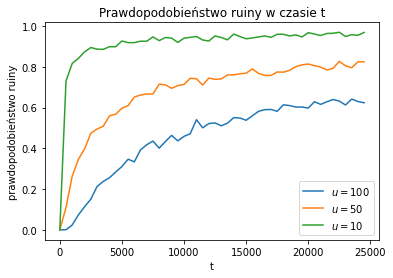

In [246]:
probability(1,1,1,1,1,1,1) # wywołanie w celu kompilacji

n = 10**3
u = 100
probs = np.zeros(50)
times = np.array([500 * i for i in range(50)])
for i in range (len(times)):
    probs[i] = probability(u, c, T, lmbd, intensity, times[i], n)
plt.plot(times, probs, label = "$u = 100$")

u = 50
probs = np.zeros(50)
times = np.array([500 * i for i in range(50)])
for i in range (len(times)):
    probs[i] = probability(u, c, T, lmbd, intensity, times[i], n)
plt.plot(times, probs, label = "$u = 50$")

u = 10
probs = np.zeros(50)
times = np.array([500 * i for i in range(50)])
for i in range (len(times)):
    probs[i] = probability(u, c, T, lmbd, intensity, times[i], n)
plt.plot(times, probs, label = "$u = 10$")

plt.legend()
plt.xlabel("t")
plt.ylabel("prawdopodobieństwo ruiny")
plt.title("Prawdopodobieństwo ruiny w czasie t")
plt.show()

**Wnioski:**
* Wykres prawdopodobieństwa ruiny będzie się różnił w zależności od dobrancyh parametrów procesu, jednak w każdym przypadku przybiera on kształt wykresu logarytmicznego. Oznacza to, że prawdopodobieństwo ruiny rośnie wraz z upływem czasu.
* Możemy również zauważyć, że im większy jest kapitał początkowy, tym mniejsze jest prawdopodobieństwo ruiny. Analogiczną własność będzie przejawiał dryf, ponieważ zwiększenie jego wartości będzie skutkowało szybszym wzrostem kapitału pomiędzy szkodami.

## 5. Rozkład stacjonarny łańcucha Markowa.

W tym zadaniu zaimplementowaliśmy algorytm służący do generowania łańcucha Markowa dla zadanych stanów oraz macierzy przejścia (dla czasu dyskretnego). W naszym przypadku rozważyliśmy stany $\{1, 2, 3\}$ oraz następującą macierz przejścia:
$$P = \left[\begin{array}{ccc}
0.5&0.5&0\\
0&0.5&0.5\\
0.5&0&0.5
\end{array}\right].$$
W pierwszej części zadania wygenerowaliśmy trajektorie łańcucha Markowa dla powyższych parametrów. Następnie, dla wszystkich możliwych stanów początkowych oraz różnych długości łańcucha, przeanalizowaliśmy zjawisko osiągania przez niego stanu stacjonarnego.

In [247]:
def MarkovChain(states, x0, P, n):
    """Funkcja przyjmuje cztery argumenty:
    states - tablica stanów
    x0 - stan początkowy
    P - macierz przejścia
    n - długość łańcucha
    
    Zwraca tablicę z kolejnymi stanami 
    osiąganymi na przestrzeni czasu
    
    Służy do generowania łańcucha Markowa 
    w czasie dyskretnym dla zadanych parametrów"""
    
    res = np.zeros(n + 1)
    id = x0
    res[0] = x0
    for i in range(1, n + 1):
        id = np.random.choice(states, p = P[id - 1])
        res[i] = states[id - 1]
    return res

#### 5.1 Wykres pojedynczej trajektorii:

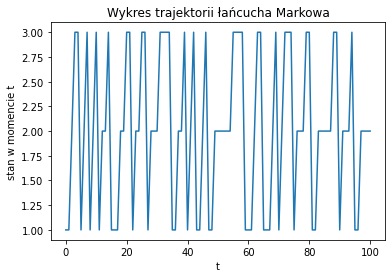

In [248]:
P = np.array([[0.5, 0.5, 0], [0, 0.5, 0.5], [0.5, 0, 0.5]])
states = np.array([1, 2, 3])
x0 = 1
n = 100

y = MarkovChain(states, x0, P, n)
t = np.array([i for i in range(len(y))])
plt.plot(t, y)
plt.title("Wykres trajektorii łańcucha Markowa")
plt.xlabel("t")
plt.ylabel("stan w momencie t")
plt.show()

#### 5.2 Stany stacjonarne:

Czas generowania poniższych wykresów jest długi. Wynika to z tego, że sprawdzamy bardzo duże długości łańcuchów, żeby otrzymany wykres w zadowalający sposób pokazywał tendencję procesu do osiągania stanów stacjonarnych.

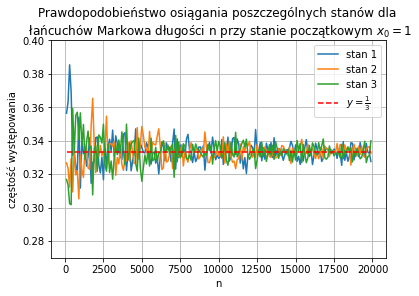

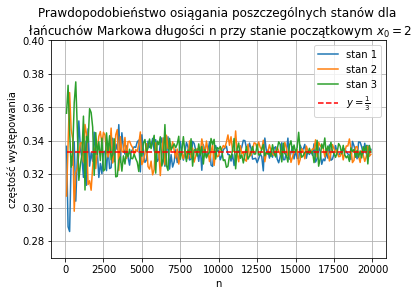

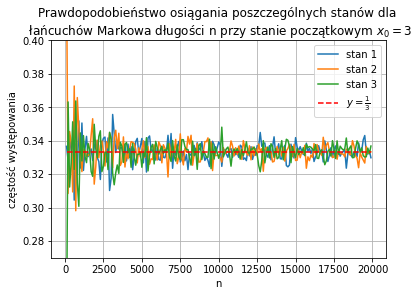

In [249]:
k = 199
n = np.array([100 * (i + 1) for i in range(k)])

for j in range(len(states)):
    x0 = states[j]
    c1 = np.zeros(k)
    c2 = np.zeros(k)
    c3 = np.zeros(k)

    for i in range(k):
        Mch = MarkovChain(states, x0, P, n[i])
        m = len(Mch)
        c1[i] = np.count_nonzero(Mch == 1)/m
        c2[i] = np.count_nonzero(Mch == 2)/m
        c3[i] = np.count_nonzero(Mch == 3)/m

    plt.plot(n, c1, label = "stan 1")
    plt.plot(n, c2, label = "stan 2")
    plt.plot(n, c3, label = "stan 3")
    plt.plot(n, np.array([1/3 for i in range(k)]), "r--", label = r"$y = \frac{1}{3}$")
    plt.title(f"Prawdopodobieństwo osiągania poszczególnych stanów dla \n łańcuchów Markowa długości n przy stanie początkowym $x_0 = {x0}$") 
    plt.xlabel("n")
    plt.ylim(0.27, 0.4)
    plt.ylabel("częstość występowania")
    plt.legend()
    plt.grid()
    plt.show()

**Wnioski:**
* Możemy zauważyć, że niezależnie od doboru stanu początkowego, łańcuch osiąga stan stacjonarny i częstości występowania poszczególnych stanów oscylują wokół wartości $y = \frac{1}{3}$.
* Już dla łańcuchów długości $5000$ obserwujemy niewiele wartości ekstremalnie odchylonych.


## 6. Czas wyjścia.

Poniżej zaimplementowaliśy prosty algorytm służący do liczenia czasu wyjścia ruchu Browna 2D z kuli jednostkowej

In [250]:
@njit
def times_array(n, d_t):
    """
    Funkcja zliczająca czas wyjścia ruchu Browna 2D z kuli jednostkowej
    Przyjmuje parametry:
    n - ilość symulacji ruchu browna
    d_t - odstęp czasowy pomiędzy kolejnymi ruchami

    zwraca parametr:
    outputs - tablica zawierająca 'n' czasów wyjścia
    """
    outputs = np.empty(n)
    for i in range(n):
        x = 0
        y = 0
        time_of_exit = 0
        while x**2 + y**2 < 1:
            x += np.random.normal(0, np.sqrt(d_t))
            y += np.random.normal(0, np.sqrt(d_t))
            time_of_exit += dt
        outputs[i] = time_of_exit
    return outputs


dt = 0.01
trajectories = 10**5   # liczba wykonywanych prób

times = times_array(trajectories, dt)

Otrzymaliśmy poniższy rozkład:

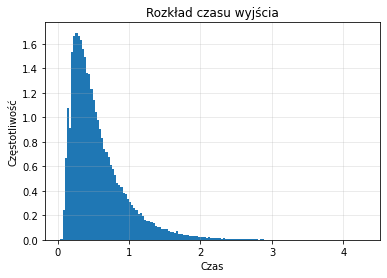

In [251]:
bins = np.arange(np.min(times), np.max(times), 3*dt)
binss, counts = np.histogram(times, density=True, bins=bins)
plt.hist(times, density=True, bins=bins)
plt.title("Rozkład czasu wyjścia")
plt.xlabel("Czas")
plt.ylabel("Częstotliwość")
plt.grid(alpha=0.3)
plt.show()

Za pomocą biblioteki Fitter dla otrzymanego rozkładu znaleźliśmy dopasowania najbardziej prawdopodobnych znanych rozkładów. Wybraliśmy pięć najlepszych rezultatów.

Fitting 5 distributions:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting 5 distributions: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
fatiguelife,0.269002,847.046186,-1.282562e+06,inf,0.010189,1.904211e-09
betaprime,0.369051,770.865052,-1.250928e+06,inf,0.020168,9.138163e-36
f,0.369051,770.863764,-1.250928e+06,inf,0.020169,9.128745e-36
exponnorm,0.399642,837.397345,-1.242977e+06,inf,0.025467,8.972436e-57
burr12,0.578408,742.845609,-1.205994e+06,inf,0.027876,6.097663e-68


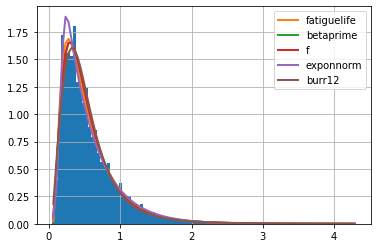

In [252]:
f = Fitter(times, distributions=["fatiguelife", "betaprime", "f", "exponnorm", "burr12"])
f.fit()
f.summary()

Pomimo tego, że wizualnie rozkłady wydają się niemalże idealne, _p-wartości_ są niezwykle bliskie zera, przez co musimy odrzucić nasze hipotezy zerowe o ich zgodności z otrzymanymi danymi.